In [1]:
%load_ext rpy2.ipython

- Project '~/git/PopBERT' loaded. [renv 1.0.5]


In [2]:
import pandas as pd
from sklearn import preprocessing

import src

In [3]:
%%R

library(tidyverse)
library(ggplot2)
library(ggpattern)
theme_set(theme_minimal())
library(scales)
library(here)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

here() starts at /Users/lukas/git/PopBERT


# Load data

In [4]:
df = pd.read_parquet(src.PATH / "data/raw/sentences.parquet.gzip")
preds = pd.read_parquet(src.PATH / "data/interim/sentence_predictions.parquet.gzip")

df = pd.merge(df, preds, on="sample_id")

In [5]:
thresh = {"elite": 0.415961, "pplcentr": 0.295400, "left": 0.429109, "right": 0.302714}

In [6]:
for key, val in thresh.items():
    df[key] = df[key].apply(lambda x: 1 if x > val else 0)

In [7]:
df.abbreviation.unique()

array(['CDU/CSU', 'FDP', 'AfD', 'DIE LINKE', 'Grüne', 'SPD'], dtype=object)

In [8]:
colormap = {
    "CDU/CSU": "#000000",
    "Grüne": "#1AA037",
    "DIE LINKE": "#8B008B",  # SPD complementary for visual disambiguation
    "FDP": "#FFEF00",
    "AfD": "#0489DB",
    "SPD": "#E3000F",
}
color_names = list(colormap.keys())
color_vals = list(colormap.values())

In [9]:
%%R -i color_names -i color_vals
colors <- setNames(color_vals, color_names)

In [10]:
plot = df.drop("text", axis=1).dropna()
plot.abbreviation = plot.abbreviation.astype("category")

In [11]:
plot_df = (
    df.groupby(["electoral_term", "abbreviation"])
    .mean(numeric_only=True)
    .reset_index()
    .rename(
        {
            "abbreviation": "Party",
            "elite": "(a) Anti-Elitism",
            "pplcentr": "(b) People-Centrism",
            "left": "(c) Left-Wing Host-Ideology",
            "right": "(d) Right-Wing Host-Ideology",
        },
        axis=1,
    )
)

cols = [
    "(a) Anti-Elitism",
    "(b) People-Centrism",
    "(c) Left-Wing Host-Ideology",
    "(d) Right-Wing Host-Ideology",
]

plot_df_norm = plot_df.copy()
for col in cols:
    plot_df_norm[col] = preprocessing.maxabs_scale(plot_df_norm[col])


def reshape_df(df):
    new = pd.melt(df, id_vars=["Party", "electoral_term"], value_vars=cols, var_name="variable")
    new["Party"] = new.Party.astype("category")
    return new


plot_df = reshape_df(plot_df)
plot_df_norm = reshape_df(plot_df_norm)

In [12]:
plot_df.Party.unique()

['CDU/CSU', 'DIE LINKE', 'Grüne', 'SPD', 'AfD', 'FDP']
Categories (6, object): ['AfD', 'CDU/CSU', 'DIE LINKE', 'FDP', 'Grüne', 'SPD']

In [13]:
%%R -i plot_df -i plot_df_norm 


create_plot <- function(df, log_y="identity", scales="free") {
    df$electoral_term <- as_factor(df$electoral_term)
    df$variable <- fct_relevel(df$variable, c("(a) Anti-Elitism", "(b) People-Centrism", "(c) Left-Wing Host-Ideology", "(d) Right-Wing Host-Ideology"))
    df <- complete(df, Party = unique(df$Party), electoral_term = unique(df$electoral_term), variable = unique(df$variable), fill=list(value=0))
    plot <- ggplot(df, aes_string(x="Party", y="value", fill="Party", pattern="electoral_term")) +
        geom_bar_pattern(
            position=position_dodge(preserve="single"),
            stat="identity",
            color="grey",
            pattern_fill="grey",
            pattern_angle=45,
            pattern_density=0.1,
            pattern_spacing=0.025,
            pattern_key_scale_factor=0.6
            ) +
        scale_fill_manual(values=colors) +
        scale_pattern_manual(values=c("18"="stripe", "19"="none")) +
        scale_y_continuous(trans=log_y) +
        theme(
            text=element_text(size=18),
            axis.text=element_text(size=14),
            axis.text.x=element_blank(), 
            axis.title.y=element_blank(),
            axis.title.x=element_blank(),
            strip.text=element_text(size=20)
        ) +
        facet_wrap("~variable", scales=scales) +
        guides(pattern = guide_legend(title="Term", override.aes = list(fill = "white")),
            fill = guide_legend(override.aes = list(pattern = "none")))
        
        return(plot)

}


In addition: Warning message:
`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


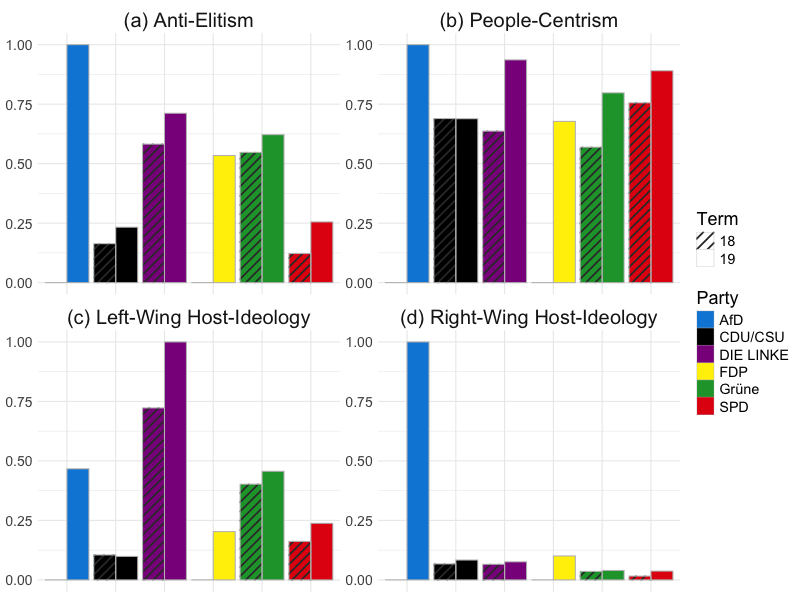

In [14]:
%%R -w 800 -h 600
plot <- create_plot(plot_df_norm, scales="free")
ggsave(here("results", "figures", "all_dimensions_normalized.pdf"), width=16, height=9)
plot